In [1]:
import numpy  as np
import json
import matplotlib.pylab as plt
import copy
import cv2
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from tqdm import tqdm
import torch
from collections import OrderedDict
from pathlib import Path
import random

In [2]:
damage = 'scratch'
path = Path('/mmdetection/data/merimen_coco/19_02_2022/'+damage)
data = json.load(open(path/'annotations'/'clean_v1.json'))
print(len(data['images']),len(data['annotations']))

81933 155036


In [3]:
if damage == 'dent':
    #config_file = '../configs/detectors/dent_detector_latest_segm.py'
    #checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'
    config_file = '../models/cbnet/dent_pseudo/dent_pseudo.py'
    checkpoint_file = '../models/cbnet/dent_pseudo/epoch_30.pth'

if damage == 'loose':
    config_file = '../models/loose/loose.py'
    checkpoint_file = '../models/loose/epoch_9.pth'

if damage == 'crack':
    config_file = '../checkpoints/combine_crack_phase_1/combine_crack.py'
    checkpoint_file = '../checkpoints/combine_crack_phase_1/epoch_28.pth'

if damage == 'scratch':
    config_file = '/mmdetection/checkpoints/scratch-cp-exp5-HSV-LSJ-SWA/swa-scratch-copy-paste-HSV-LSJ.py'
    checkpoint_file = '/mmdetection/checkpoints/scratch-cp-exp5-HSV-LSJ-SWA/best_bbox_mAP.pth'
    #config_file = '../models/scrach_mosaic_5k/scratch_mosaic_detectors.py'
    #checkpoint_file = '../models/scrach_mosaic_5k/epoch_9.pth'
if damage == 'combine_missing':
    config_file = '../work_dirs/missing/missing.py'
    checkpoint_file = '../work_dirs/missing/epoch_10.pth'


In [25]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


In [26]:
def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    #print(box1,box2)
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

In [28]:
pseudo_data = copy.deepcopy(data)
pseudo_data['images'] = []
pseudo_data['annotations'] = []

#image_id = 0
annotation_id = 0
num_tp = 0
for idx,img in enumerate(tqdm(data['images'])):
    #if idx == 12499 :
    #    continue
    image = cv2.imread(str(path/'images'/img['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.1)

    annos = [[(int(a['bbox'][0]),int(a['bbox'][1])),(int(a['bbox'][0]+a['bbox'][2]),int(a['bbox'][1]+a['bbox'][3]))] 
             for a in data['annotations'] if a['image_id']==img['id']]

    pseudo_segms = []
    check_ol = [True for i in annos]
    
    for i,box in enumerate(pred_boxes):
        ious = [cal_iou(image,box,a) for a,check in zip(annos,check_ol) if check]
        
        if len(ious) == 0 :
            break
            
        idx = np.argmax(ious)
        
        if ious[idx] >= 0.15:
            #print(box)
            pseudo_segms.append(pred_segms[i])
            check_ol[idx] = False
    num_tp += len(pseudo_segms)
    
    if len(pseudo_segms) == 0:
        continue
        
    # check fully matching    
    if len(pseudo_segms) != len(annos):
        continue
        
    pseudo_data['images'].append(img)
    
    for segm in pseudo_segms:
        semg = np.array(segm).astype(np.uint8)
        contours, hierarchy = cv2.findContours(semg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            annotation = OrderedDict()
            annotation['id'] = annotation_id
            annotation_id += 1
            annotation['image_id'] = img['id']
            annotation['category_id'] = 0
            annotation['area'] = cv2.contourArea(c)
            c = np.array(c).reshape(-1,2)
            xmax = max(c[:,0])
            xmin = min(c[:,0])
            
            ymax = max(c[:,1])
            ymin = min(c[:,1])
            
            w = xmax - xmin
            h = ymax - ymin
            
            annotation['bbox'] = [int(xmin),int(ymin),int(w),int(h)]
            annotation['segmentation'] = c.reshape(1,-1).tolist()
            
            pseudo_data['annotations'].append(annotation)
print('num tp : ',num_tp)
    
with open(path/'annotations'/'pseudo_fully_matching.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

  0%|                                                                                                                                                                           | 0/81933 [00:00<?, ?it/s]/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/mmdetection/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81933/81933 [3:22:24<00:00,  6.75it/s]


num tp :  130058


In [8]:
print('racall rate : ',num_tp/len(data['annotations']))

racall rate :  0.873130543626044


In [32]:
pseudo_data = json.load(open(path/'annotations'/'pseudo_fully_matching.json'))
print(len(pseudo_data['images']),len(pseudo_data['annotations']))

47384 79377


In [33]:
pseudo_data = clean_zero_area_annotations(pseudo_data)

number annotation b4 clean :  79377  images :  47384
cleaning ... 
number annotation after cleand :  77559  images :  47384


In [31]:
def clean_zero_area_annotations(js_data):
    print('number annotation b4 clean : ',len(js_data['annotations']), ' images : ',len(js_data['images']))
    print('cleaning ... ')
    js_data['annotations'] = [a for a in js_data['annotations'] if a['area'] != 0]
    
    print('number annotation after cleand : ',len(js_data['annotations']), ' images : ',len(set([a['image_id'] for a in js_data['annotations']])))
    
    return js_data

In [5]:
def sample(js_data):
    #i = random.choice(js_data['images'])
    num = 3
    imgs = random.sample(js_data['images'],num**2)
    #print(i['id'],i['url'])
    #num = 2 
    fig, axis = plt.subplots(num, num,figsize=(15,15))
    
    for idx,i in enumerate(imgs):
        annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) 
                 for a in js_data['annotations'] if a['image_id'] == i['id']]
        image = cv2.imread(str(path/'images'/i['file_name']))
        image = cv2.drawContours(image,annos,-1,(255,0,0),2)
        
        axis[int(idx/num),idx%num].imshow(image)
        axis[int(idx/num),idx%num].set_title(i['id'])
        
    #plt.figure(figsize=(20,10))
    #plt.imshow(image)

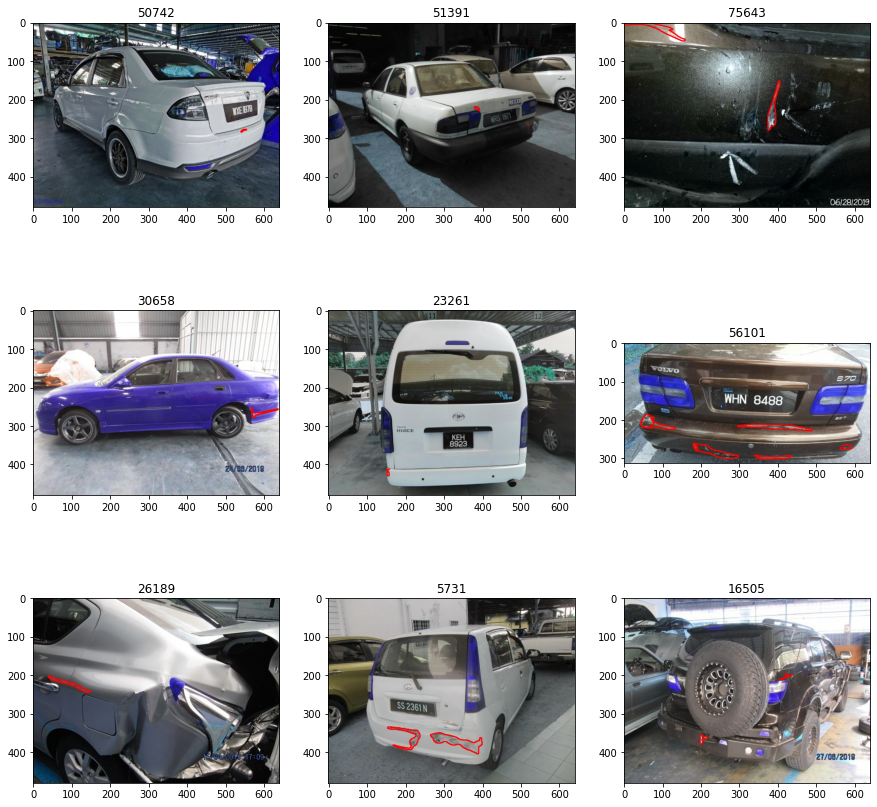

In [6]:
sample(pseudo_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77559/77559 [00:00<00:00, 90330.49it/s]


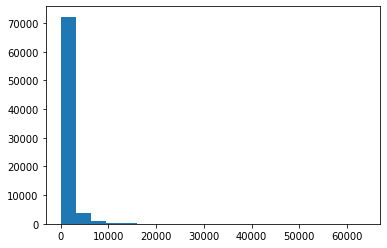

In [83]:
areas = []
ratios_segm_box = []
ratios_hw = []
anno_ids = []
# count_zero = 0
for a in tqdm(pseudo_data['annotations']):
    segm = np.array(a['segmentation']).reshape(-1,2).astype(np.int32)
    
    area_segm = cv2.contourArea(segm)
    area_bbox = a['bbox'][2]*a['bbox'][3]
    ratio_hw = min(a['bbox'][2] / a['bbox'][3],a['bbox'][3] / a['bbox'][2])
#     if area_bbox == 0:
#         print(a)
#         count_zero += 1
    
    areas.append(area_segm)
    ratios_segm_box.append(area_segm/(area_bbox+1e-12))
    ratios_hw.append(ratio_hw)
    
    anno_ids.append(a['id'])
    #print(areas)
    #break
# print(count_zero)

areas = np.array(areas)
ratios_segm_box = np.array(ratios_segm_box)
ratios_hw = np.array(ratios_hw)
anno_ids = np.array(anno_ids)

_,_,_ = plt.hist(areas,bins=20)

In [57]:
len([i for i in (ratios_hw < 0.2) if i == True])

5115

(array([7.5831e+04, 1.4560e+03, 2.2400e+02, 4.0000e+01, 4.0000e+00,
       2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]), array([5.00000e-01, 6.38230e+03, 1.27641e+04, 1.91459e+04, 2.55277e+04,
       3.19095e+04, 3.82913e+04, 4.46731e+04, 5.10549e+04, 5.74367e+04,
       6.38185e+04]), <BarContainer object of 10 artists>)
threshold :  1999.0199999999968
47601


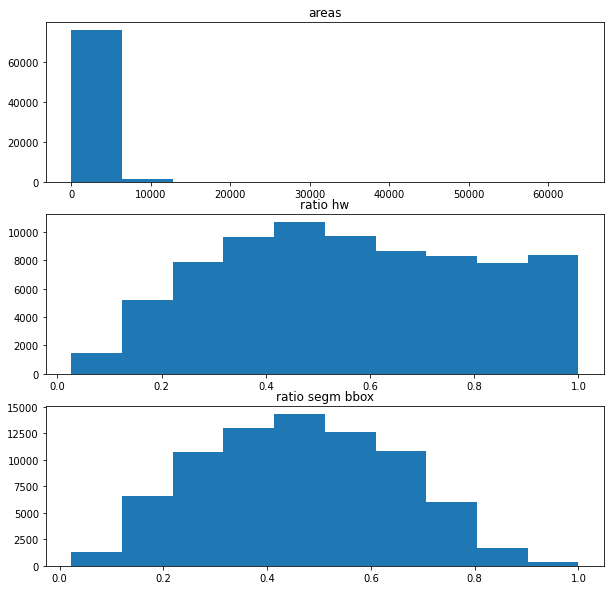

In [179]:
feature1 = areas 
feature2 = ratios_hw
feature3 = ratios_segm_box

fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(10,10))
out = ax1.hist(feature1)
#print(out)
ax1.set_title('areas')

ax2.hist(feature2)
ax2.set_title('ratio hw')

ax3.hist(feature3)
ax3.set_title('ratio segm bbox')


thres = np.quantile(feature1,0.88)
print('threshold : ',thres)
# coor = feature1 >= thres
# coor = np.logical_and(feature1 > 2000, feature1 < thres)
# coor = np.logical_and(feature1 < 0.4, feature2 < 0.4)
# annotations = np.array(pseudo_data['annotations'])[coor]
print(len(annotations))

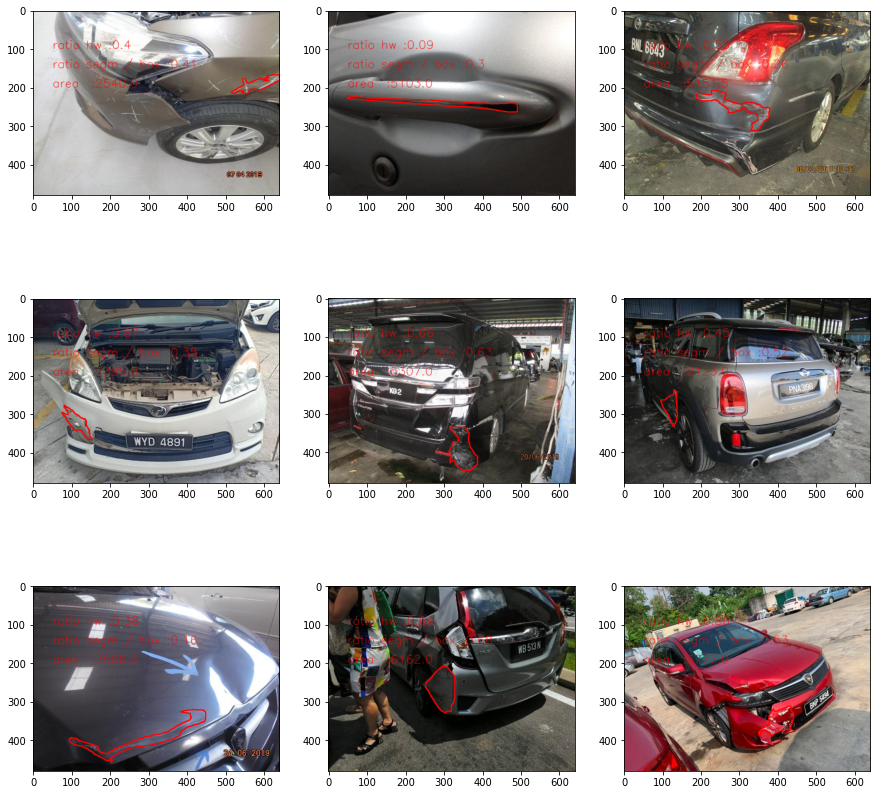

In [172]:
plot_annotations(pseudo_data,annotations.tolist())

In [173]:
def plot_annotations(js_data,annotations):
    num = 3
    
    if len(annotations) > num**2:
        annotations = random.sample(annotations,num**2)
    
    fig, axis = plt.subplots(num, num,figsize=(15,15))
    
    for idx,annotation in enumerate(annotations):
        img = [i for i in js_data['images'] if i['id']==annotation['image_id']][0]
        image = cv2.imread(str(path/'images'/img['file_name']))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        segm = np.array(annotation['segmentation']).reshape(-1,2).astype(np.int32)
        image = cv2.drawContours(image,[segm],-1,(255,0,0),2)
        
        ratio_hw = min(annotation['bbox'][2]/annotation['bbox'][3],annotation['bbox'][3]/annotation['bbox'][2])
        #print(ratio_hw)
        
        image = cv2.putText(image,'ratio hw :'+str(round(ratio_hw,2)),(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),1,cv2.LINE_AA)
        image = cv2.putText(image,'ratio segm / box :'+str(round(cv2.contourArea(segm)/(annotation['bbox'][2]*annotation['bbox'][3]),2)),(50,150),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),1,cv2.LINE_AA)
        image = cv2.putText(image,'area  :'+str(round(cv2.contourArea(segm),2)),(50,200),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),1,cv2.LINE_AA)
        
        axis[int(idx/num),idx%num].imshow(image)
    
#     plt.imshow(image)

def classify_annotation(annotation):
    segm = np.array(annotation['segmentation']).reshape(-1,2).astype(np.int32)
    area_segm = cv2.contourArea(segm)
    area_bbox = annotation['bbox'][2]*annotation['bbox'][3]
    
    ratio_segm_box = area_segm/area_bbox
    ratio_hw = min(annotation['bbox'][2] / annotation['bbox'][3],annotation['bbox'][3]/annotation['bbox'][2])
    
    # check thin scratch
    if ratio_hw <= 0.15 or ratio_segm_box <= 0.27:
        return 'thin'
    
    if ratio_hw < 0.4 and ratio_segm_box < 0.4 :
        return 'thin'
    
    if area_segm < 390 :
        return 'small'
    
    if area_segm > 2000 : 
        return 'big'

    return 'normal'
    

[array([[208, 385],
       [207, 386],
       [199, 386],
       [198, 387],
       [196, 387],
       [195, 388],
       [195, 390],
       [196, 391],
       [196, 392],
       [195, 393],
       [197, 395],
       [200, 395],
       [201, 394],
       [211, 394],
       [212, 393],
       [210, 391],
       [210, 389],
       [209, 388],
       [209, 387],
       [208, 386]], dtype=int32), array([[462, 370],
       [461, 371],
       [452, 371],
       [451, 372],
       [446, 372],
       [444, 374],
       [443, 374],
       [441, 376],
       [440, 376],
       [438, 378],
       [437, 378],
       [435, 380],
       [435, 381],
       [436, 381],
       [439, 384],
       [439, 385],
       [440, 386],
       [440, 391],
       [439, 392],
       [437, 392],
       [436, 393],
       [432, 393],
       [431, 394],
       [429, 394],
       [428, 395],
       [423, 395],
       [422, 396],
       [418, 396],
       [417, 397],
       [412, 397],
       [411, 398],
       [407, 39

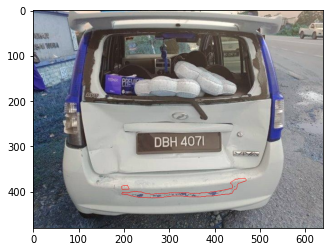

In [36]:
i = [i for i in pseudo_data['images'] if i['id']==59056][0]
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in pseudo_data['annotations'] 
         if a['image_id']==i['id']]
print(annos)

image = cv2.imread(str(path/'images'/i['file_name']))
image = cv2.drawContours(image,annos,-1,(255,0,0),1)
plt.imshow(image)

In [181]:
new_images = []
for i in tqdm(pseudo_data['images']):
    annotations = [a for a in pseudo_data['annotations'] if a['image_id']==i['id']]
    
    types = [classify_annotation(a) for a in annotations]
    
    if 'normal' not in types and 'big' not in types:
        new_images.append(i)
        continue
    
    if 'big' in types:
        continue
        
    if len(types) > 6 :
        new_images.append(i)
        #print('density check !!')
        continue
    
    if len([0 for t in types if t=='normal']) < 0.5*len(types):
        new_images.append(i)
        continue
print(len(new_images))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29570/29570 [10:18<00:00, 47.79it/s]

29570


In [176]:
ids = [i['id'] for i in new_images]
annotations = [a for a in pseudo_data['annotations'] if a['image_id'] in ids]

pseudo_data['images']= new_images
pseudo_data['annotations'] = annotations

with open(path/'annotations'/'pseudo_fully_matching_filter_type.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_data, f, ensure_ascii=False, indent=4)

In [177]:
print(len(pseudo_data['images']),len(pseudo_data['annotations']))

29570 47601


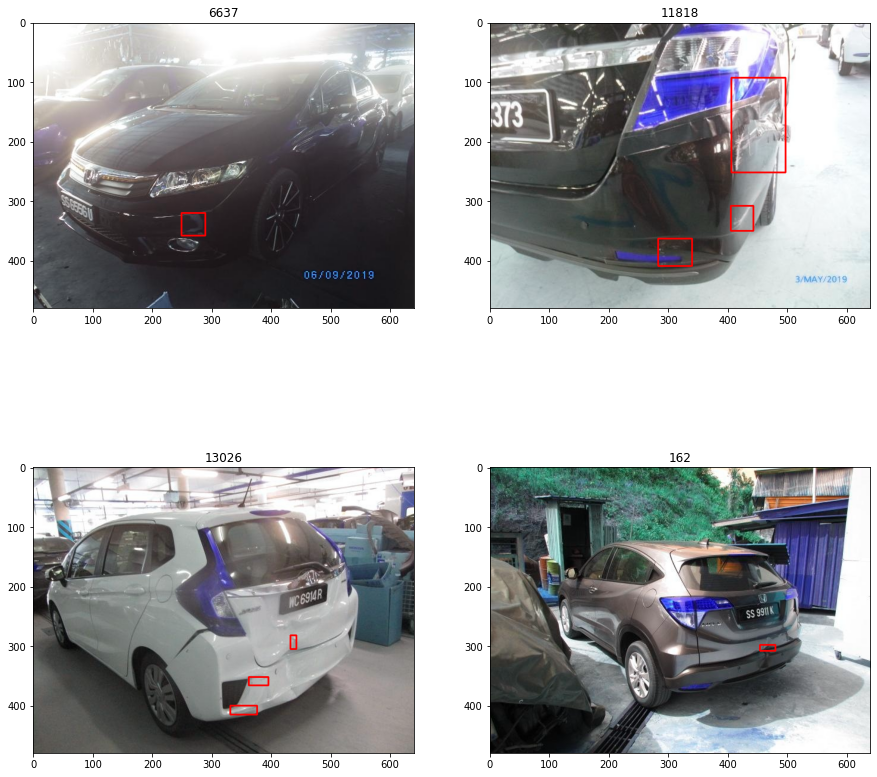

In [4]:
sample(data)

In [65]:
dent : 5559/8458

0.657247576259163

[0.75199556 0.73157185 0.695713   0.6118857  0.58441585 0.40423203
 0.3962766  0.37643495 0.36313763 0.28702688 0.14995311 0.13493355
 0.12455233 0.11272437] 14


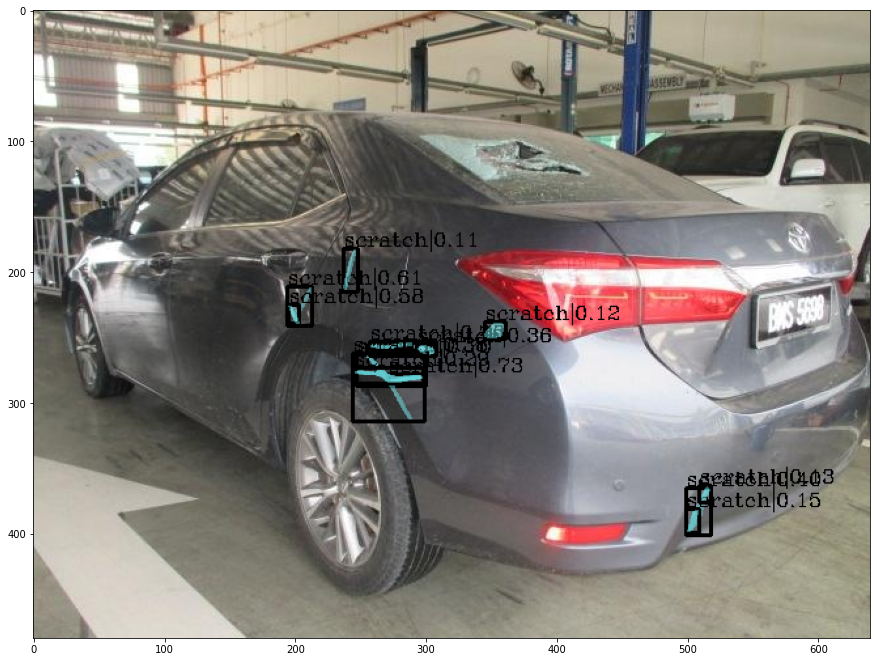

In [15]:
img_data = data['images'][0]
image = cv2.imread(str(path/'images'/img_data['file_name']))

result = inference_detector(model, image)
img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.1)

print(pred_scores,len(pred_scores))
plt.figure(figsize=(15,15))
plt.imshow(img_)

[0.7466092  0.6885893  0.6862794  0.58066016 0.35867363 0.3094387
 0.29100868] 7


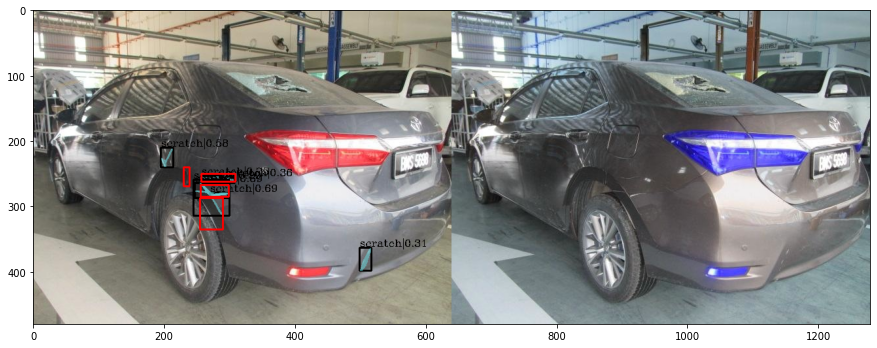

In [22]:
img_data = data['images'][0]
image = cv2.imread(str(path/'images'/img_data['file_name']))

result = inference_detector(model, image)
img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.2)

annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) 
                 for a in data['annotations'] if a['image_id'] == img_data['id']]

img_ = cv2.drawContours(img_,annos,-1,(255,0,0),2)

print(pred_scores,len(pred_scores))
plt.figure(figsize=(15,15))
plt.imshow(np.hstack((img_,image)))

In [5]:
damage = 'carpart'
path = Path('/mmdetection/data/'+damage)
data = json.load(open(path/'annotations'/'test.json'))
print(len(data['images']),len(data['annotations']))

983 12932


In [8]:
outpath = 'testing_cp'
Path(outpath).mkdir(parents=True,exist_ok=True)
for i in tqdm(data['images']):
    img = cv2.imread(str(path/'images'/i['file_name']))
    cv2.imwrite(outpath+'/'+i['file_name'],img)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 983/983 [01:00<00:00, 16.12it/s]
